# WGAN on MNIST

In [3]:
%matplotlib inline

import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data

import pickle
import numpy as np
from tqdm import tqdm

import matplotlib.pyplot as plt

In [4]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('../data')

Extracting ../data/train-images-idx3-ubyte.gz
Extracting ../data/train-labels-idx1-ubyte.gz
Extracting ../data/t10k-images-idx3-ubyte.gz
Extracting ../data/t10k-labels-idx1-ubyte.gz


In [11]:
!mkdir chck

In [81]:
# Create WGAN model
class WGAN():
    def __init__(self, io_size, z_dim, hidden_size, alpha=0.2, smooth=0.9, clip=0.01, build=True):
        # sizes
        self.io_size = io_size
        self.z_dim = z_dim
        self.hidden_size = hidden_size
        self.alpha = alpha
        self.smooth = smooth
        self.clip = clip
        
        # graph config
        self.gc = dict()
        
        if build:
            self.build()
            # Save names
            self.set_gc_names()
            
    def placeholders(self):
        self.input = tf.placeholder(tf.float32, shape=[None, self.io_size], name='input')
        self.z = tf.placeholder(tf.float32, shape=[None, self.z_dim], name='z')
            
    def generator(self, i, reuse=False):
        with tf.variable_scope('generator', reuse=reuse):
            layer = tf.contrib.layers.fully_connected(i, self.hidden_size, activation_fn=None)
            layer = tf.maximum(self.alpha*layer, layer)
            out = tf.contrib.layers.fully_connected(layer, self.io_size, activation_fn=tf.sigmoid)
            
            return out 
    
    def discriminator(self, X, reuse=False):
        with tf.variable_scope('discriminator', reuse=reuse):
            layer = tf.contrib.layers.flatten(X)
            layer = tf.contrib.layers.fully_connected(layer, self.hidden_size, activation_fn=None)
            layer = tf.maximum(self.alpha*layer, layer)
            logits = tf.contrib.layers.fully_connected(layer, 1, activation_fn=None)
            
            return logits     
            
    def build(self):
        self.placeholders()
        
        self.sample = self.generator(self.z)
        fake_logits = self.discriminator(self.sample)
        real_logits = self.discriminator(self.input, reuse=True)
        
        # Loss functions
        dloss_fake = tf.reduce_mean(fake_logits)
        dloss_real = tf.reduce_mean(real_logits)
        self.dloss = dloss_fake - dloss_real
        
        self.gloss = -tf.reduce_mean(fake_logits)
        
        # Trainable parameters
        gvars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='generator')
        dvars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='discriminator')
        
        # Discriminator parameter clipping
        self.op_instclip = [v.assign(tf.clip_by_value(v, -self.clip, self.clip)) for v in dvars]

        # Optimizers
        self.train_discriminator = tf.train.AdamOptimizer(1e-4).minimize(self.dloss, var_list=dvars)
        self.train_generator = tf.train.AdamOptimizer(1e-4).minimize(self.gloss, var_list=gvars)
    
    def set_gc_names(self):
        for k, v in self.__dict__.items():
            if isinstance(v, tf.Tensor) or isinstance(v, tf.Operation):
                self.gc[k] = self.__dict__[k].name
            if isinstance(v, list):
                if all(map(lambda x: isinstance(x, tf.Tensor) or isinstance(x, tf.Operation), v)):
                    self.gc[k] = [_.name for _ in v]
        
    def print_gc_names(self):
        for k, n in self.gc.items():
            print(k, n)
            
    def get_from_graph(self, name, graph):
        try:
            return graph.get_tensor_by_name(name)
        except:
            try:
                return graph.get_operation_by_name(name)
            except:
                raise 
           
    def init_from_graph(self, graph, gc):
        self.gc = gc
        for k, n in self.gc.items():
            if isinstance(n, list):
                self.__dict__[k] = [self.get_from_graph(_, graph) for _ in n]
            else:
                self.__dict__[k] = self.get_from_graph(n, graph)    

In [91]:
# Train the model and save it
io_size, z_dim, hidden_size = 784, 4, 512
batch_size = 32
nepochs = 200
discriminator_train_steps = 5
restore_model = True # False, True

tf.reset_default_graph()
if restore_model:    
    model = WGAN(io_size, z_dim, hidden_size, build=False)    
else:
    model = WGAN(io_size, z_dim, hidden_size)
    with open('chck/wgan.pickle', 'wb') as f:
        pickle.dump(model.gc, f)

with tf.Session() as sess:
    if restore_model:
        saver = tf.train.import_meta_graph('chck/wgan.meta')
        saver.restore(sess, "chck/wgan")
        with open('chck/wgan.pickle', 'rb') as f:
            gc = pickle.load(f) 
        model.init_from_graph(sess.graph, gc)
    else:
        sess.run(tf.global_variables_initializer())
        saver = tf.train.Saver()

    with tqdm(desc='Epoch', total=mnist.train.num_examples*nepochs, unit=' examples') as pbar:
        dloss, gloss = 0.0, 0.0
        dlosses, glosses = [], []
        samples = []
        for epoch in range(nepochs):
            for batch_idx in range(int(mnist.train.num_examples//batch_size)):
                # image batch
                batch = mnist.train.next_batch(batch_size)
                # noise batch
                noise_batch = np.random.uniform(-1.0, 1.0, size=(batch_size, model.z_dim)) 
                # Train discriminator
                _, _, dloss = sess.run([model.train_discriminator, model.op_instclip, model.dloss], 
                                feed_dict={model.input: batch[0], model.z: noise_batch})
                # Train generator
                if batch_idx % discriminator_train_steps == (discriminator_train_steps-1):
                    _, gloss = sess.run([model.train_generator, model.gloss], 
                                feed_dict={model.z: noise_batch})
                
                pbar.set_description('Epoch {:2}'.format(epoch+1))
                pbar.update(batch_size)
                pbar.set_postfix(Dloss='{:.4f}'.format(dloss), 
                                Gloss='{:.4f}'.format(gloss))
        
            # Save discriminator and generator losses
            dlosses.append(dloss)
            glosses.append(gloss)
            
            # Generate samples
            noise_batch = np.random.uniform(-1.0, 1.0, size=(batch_size, model.z_dim))
            s = sess.run(model.sample, feed_dict={model.z: noise_batch})
            samples.append(s)          

    save_path = saver.save(sess, "chck/wgan")

with open('chck/wgan_samples.pickle', 'wb') as f:
    pickle.dump(np.array(samples), f)    


INFO:tensorflow:Restoring parameters from chck/wgan


Epoch 200: 100%|█████████▉| 10995200/11000000 [14:14<00:00, 12861.74 examples/s, Dloss=-0.0581, Gloss=-0.0451]


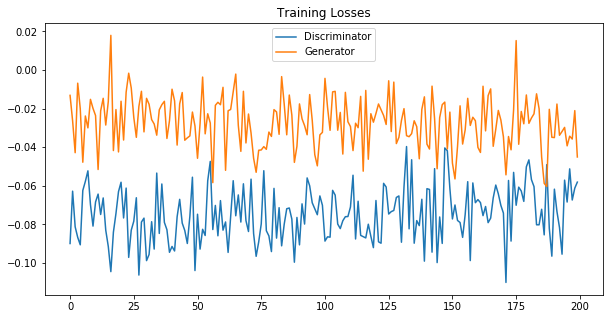

In [92]:
# Plot losses
fig, ax = plt.subplots(figsize=(10,5))
plt.plot(dlosses, label='Discriminator')
plt.plot(glosses, label='Generator')
plt.title("Training Losses")
plt.legend()

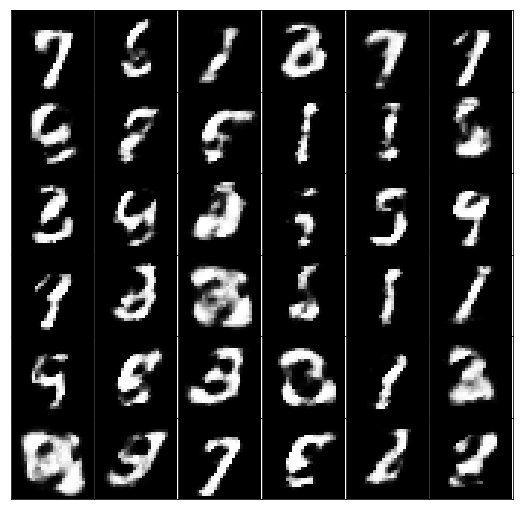

In [93]:
# Plot sample evolution in time
with open('chck/wgan_samples.pickle', 'rb') as f:
    samples = pickle.load(f)

def select_samples(samples, T, N):
    assert T <= samples.shape[0], 'T ({}) must be <= {}'.format(T, samples.shape[0])
    assert N <= samples.shape[1], 'N ({}) must be <= {}'.format(N, samples.shape[1])
    
    indices = np.arange(samples.shape[0]-1, 0, -samples.shape[0]/T)
    indices = indices.astype(np.int32)
    indices = list(reversed(indices))
    
    return samples[indices, 0:N,:]
    
def view_samples(samples):
    nrows = samples.shape[0]
    ncols = samples.shape[1]
    
    fig, axes = plt.subplots(nrows, ncols, sharex=True, sharey=True, figsize=(1.5*ncols,1.5*nrows))
    for ir in range(nrows):
        for ic in range(ncols):
            img = np.reshape(samples[ir, ic, :], (28, 28))
            axes[ir][ic].imshow(img, aspect='equal', cmap='gray')
            axes[ir][ic].xaxis.set_visible(False)
            axes[ir][ic].yaxis.set_visible(False)
    
    plt.subplots_adjust(wspace=0, hspace=0)


samples = select_samples(samples, 6, 6)
view_samples(samples)
